# TweetToVect

## Idea
Crear embeddgins de tweets.

INPUT:<br>
Array de embeddings de fasttext (ver WordEmbeddings.ipynb)<br>

OUTPUT:<br>
Embeddings (100d) de tweet.
<img src='img/red_tweet_to_vect.jpg' />

In [28]:
import pandas as pd
import numpy as np
import gensim
import seaborn as sns
from matplotlib import pyplot

In [10]:
word_model = gensim.models.fasttext.load_facebook_vectors("../models/words_fast_text.bin")

In [17]:
print('Length of vectors', len(word_model.get_vector('Hola')))

Length of vectors 100


In [18]:
df = pd.read_pickle('../datasets/tweets_cleaned.pkl')

In [21]:
df = df[df.lang=='es']

In [92]:
df.full_text

1000000284486139904    feliz día de la patria para todos los cordobes...
1000000308003696640    # 25demayo es un día en el que todos tenemos q...
1000000521158234114    feliz # díadelapatria. quiero reconocer a todo...
1000000589944639488    ahora escuela de robótica # misiones. el viceg...
1000000957688811520    🇦 🇷 ¡ feliz día de la patria ! que este # 25de...
1000001099514990592    ¡ feliz # 25demayo ! ahora, llega # demañana c...
1000002159289749505    el hombre que vino a transformar la argentina,...
1000002696584318977    el modelo económico de macri está agotado hace...
1000002938251735042    🇦 🇷 ¡ feliz día de la patria ! 🇦 🇷 # 25demayo URL
1000002945742721025    ¡ # argentina, felicitaciones por las fiestas ...
1000003551060312065    ¿ sabías qué ? la primera junta de gobierno, s...
1000004033464209408    símbolo de estos tiempos. la plaza, hoy 25 de ...
1000004537120378881    alberto fernández todos sabemos como termina e...
1000004674483900418    muchas gracias a todos los v

In [24]:
tokenize = lambda text: text.split(' ')
tweets_l = df.sample(5000).full_text.apply(lambda text: len(tokenize(text)))

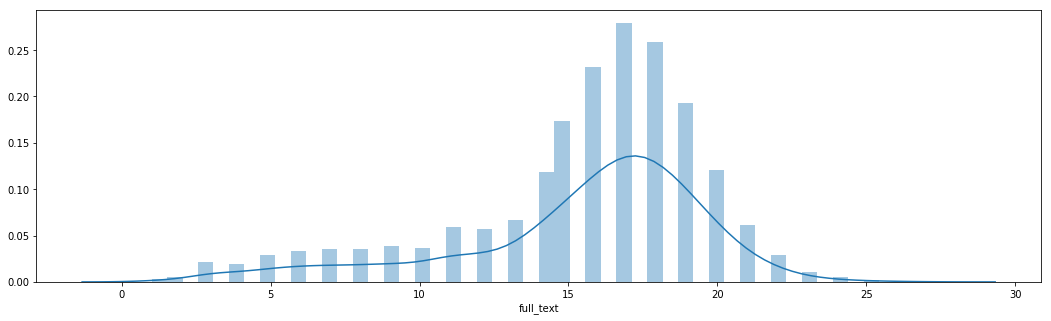

In [85]:
fig, ax = pyplot.subplots(figsize=(18,5))
sns.distplot(tweets_l)
pyplot.show()

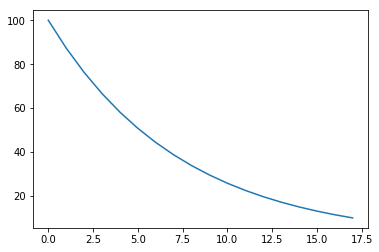

In [855]:
sns.lineplot(data=np.logspace(2, 1, num=18))

In [818]:
def get_vectors(tweet, length=18, dim=100):
    arr = [ word_model.get_vector(w) for w in tokenize(tweet) ]
    arr = np.array(arr)
    if(len(arr)==length):
        return arr
    elif(len(arr)<length):
        to_add = np.zeros((length - len(arr), dim))
        return np.concatenate([arr, to_add])
    else:
        return arr[0:length]

print(get_vectors('hi this is a tweet').shape)
print(get_vectors('hi this is a very very very very very very very very very very very very very very very long tweet with more than 25 words ! 😊').shape)

(18, 100)
(18, 100)


In [216]:
get_vectors('hi this is a tweet')

array([[ 0.23819649, -0.26781923, -0.09828454, ...,  0.66564465,
        -0.30091435,  0.21280015],
       [-0.90563112,  0.76652986,  0.02165417, ...,  1.35205889,
        -0.44202554,  0.39525443],
       [-0.2957609 ,  0.90566242, -0.07036871, ...,  0.82085109,
        -0.60953057,  0.31763369],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## keras transformer

In [131]:
import tensorflow_addons as tfa
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
import tensorflow as tf
from tensorflow.python import keras

In [888]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_layers
        })
        return config
        
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_layers,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, sentence_length, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=sentence_length, output_dim=embed_dim)

    def call(self, x):
        return x
        positions = tf.range(start=0, limit=len(x), delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [863]:
class UpscaleDense(layers.Layer):
    def __init__(self, heads, units, activation='relu'):
        super(UpscaleDense, self).__init__()
        self.heads = heads
        self.units = units
        self.denseLayer = layers.Dense(units, activation=activation)
    def call(self, x):
        x_ = [self.denseLayer(x) for _ in range(self.heads)]
        x_ = tf.keras.backend.stack(x_, axis=1)
        
        positional = layers.Embedding(input_dim=self.heads, output_dim=self.units)(tf.range(start=0, limit=25, delta=1))
        
        return x_ + positional
    
def upscaleDense(x, heads, units, activation='relu'):
    denseLayer = layers.Dense(units, activation=activation)
    x_ = [denseLayer(x) for _ in range(heads)]
    x_ = tf.keras.backend.stack(x_, axis=1)
    positional = layers.Embedding(input_dim=heads, output_dim=units)(tf.range(start=0, limit=25, delta=1))
    return x_

maxlen = 18  # Only consider the first 200 words of each movie review
embed_dim = 100  # Embedding size for each token
num_heads = 50  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,embed_dim))
pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
positions = tf.range(start=0, limit=maxlen, delta=1)

x = inputs + pos_emb(positions)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.Dense(200)(x) # shape=(None, 25, 20)
x = layers.Flatten()(x) # shape=(None, 500)
autovector = layers.Dense(150, activation='relu', name='autovector')(x)

upscaled = []
units = 100

for i in range(maxlen):
    x = layers.Dense(units, activation='relu')(autovector)
    x = layers.Dense(units, activation='linear', name='word_'+str(i))(x)
    upscaled.append(x)

output = { i:upscaled[i] for i in range(len(upscaled)) }

model = keras.Model(inputs=[inputs], outputs=output)

def cosine_loss(y_true, encodings):
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1, reduction='auto')
#     result = tf.math.multiply(cosine_loss(y_true, encodings), -1)
    return cosine_loss(y_true, encodings)

weights = np.logspace(2, 1, num=maxlen)
weights = { i:weights[i] for i in range(len(weights)) }

model.compile('adam', loss=cosine_loss)


x_t, y_t = next(data_generator(df, 10))
y_t = {i:y_t[i] for i in range(len(y_t))}
model.fit(x_t, y_t, steps_per_epoch=2, epochs=1, verbose=1)

2/2 [==============================] - 0s 13ms/step - loss: -0.5584 - word_0_loss: 0.0143 - word_1_loss: -0.0117 - word_2_loss: -0.0336 - word_3_loss: 0.0246 - word_4_loss: 0.0067 - word_5_loss: -0.0277 - word_6_loss: -0.0753 - word_7_loss: -0.0683 - word_8_loss: -0.0873 - word_9_loss: -0.0718 - word_10_loss: -0.0209 - word_11_loss: -0.0876 - word_12_loss: 0.0146 - word_13_loss: -0.0685 - word_14_loss: 0.0149 - word_15_loss: -0.0731 - word_16_loss: 0.0109 - word_17_loss: -0.0185


In [864]:
model.summary()

Model: "model_130"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_280 (InputLayer)          [(None, 18, 100)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_AddV2_115 (TensorFl [(None, 18, 100)]    0           input_280[0][0]                  
__________________________________________________________________________________________________
transformer_block_213 (Transfor (None, 18, 100)      66628       tf_op_layer_AddV2_115[0][0]      
__________________________________________________________________________________________________
dense_5480 (Dense)              (None, 18, 200)      20200       transformer_block_213[0][0]      
__________________________________________________________________________________________

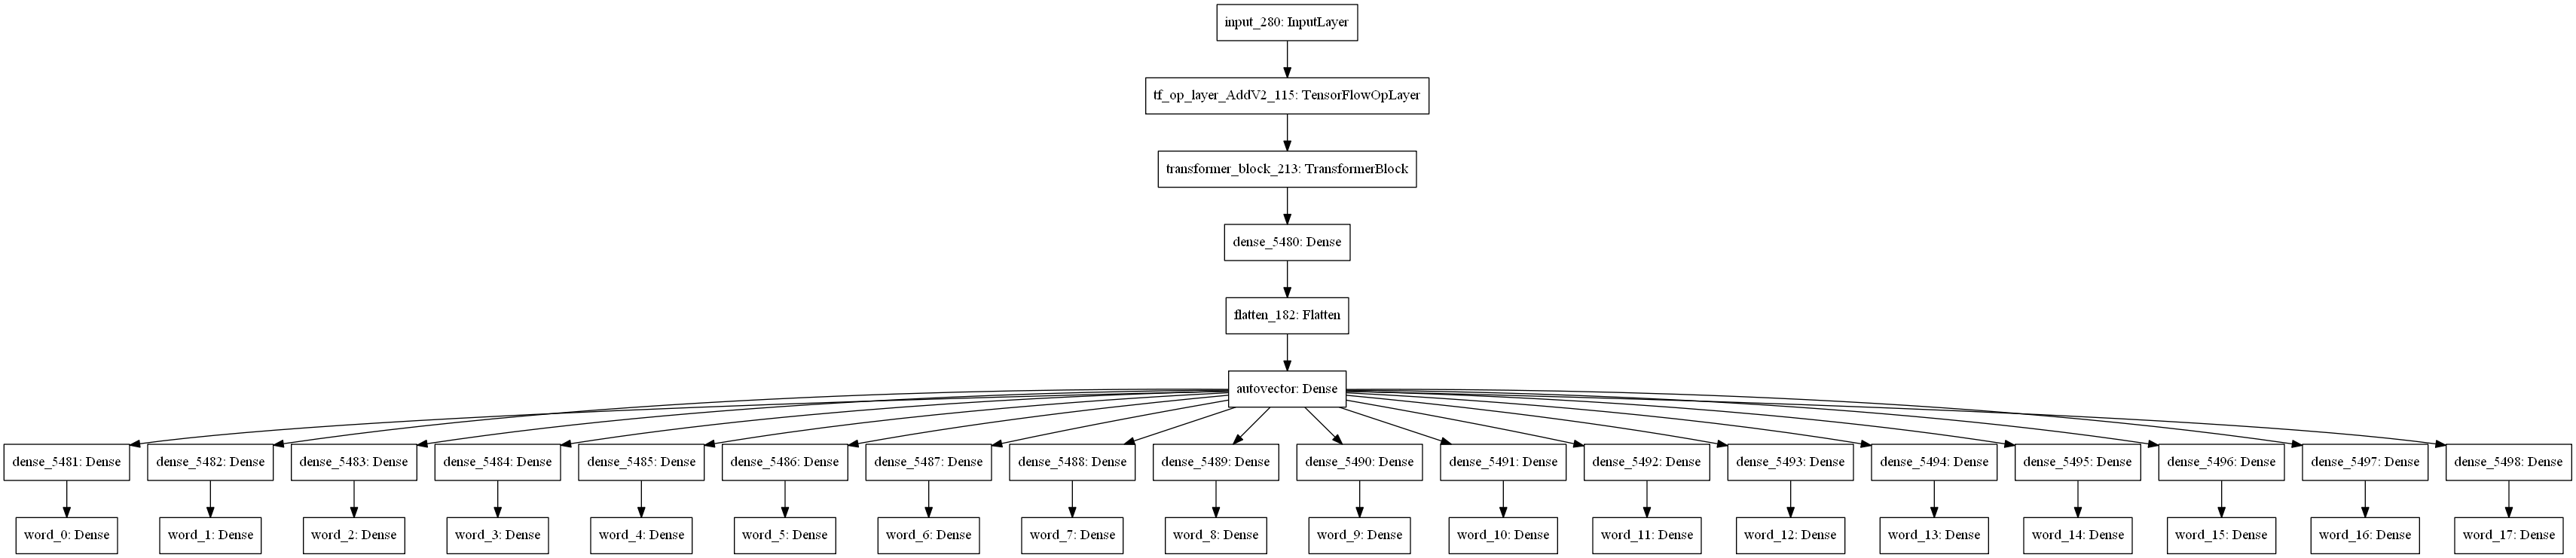

In [865]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.utils import plot_model
plot_model(model)

In [884]:
def decode_vector(vectors):
    words = [word_model.similar_by_vector(vec, topn=1)[0][0] for vec in vectors]
    return words
def test_model(samples=10):
    for i in range(samples):
        vector,y = next(data_generator(df, 1))
    #     vector = get_vectors(text, 25,100)
        words = decode_vector(vector[0])
        print(' '.join(words))

        predicted = model.predict(vector)
        predicted = [predicted[i] for i in predicted]
        predicted = np.array(predicted).transpose(1,0,2)
        words_predicted = decode_vector(predicted[0])
        print(' '.join(words_predicted))
        print('')
        
test_model(2)

la vuelta al mundo en torino salió desde la patagonia y llegó a alaska URL @ b </s>
la wl el ryuuzakii_l en tobago oklahoma en la ceibos y 87.938.624 a slim, URL @ 𝐀𝐇𝐎𝐑𝐀 y

luchamos, igual que micaela, por construir un mundo donde las mujeres no sean oprimida donde la vi </s>
estámos kk que 𝐀𝐇𝐎𝐑𝐀 por síalbienestar un 🛴 que las las no crezcan inocentes, que la 💈 de



## generator

In [882]:
def data_generator(df, batch_size, text_size=18, dim=100):
    while True:
        batch_df = df.sample(batch_size)
#         vectors_y = batch_df.full_text.apply(lambda text: get_vectors(text, text_size, dim).tolist()).values.tolist()
        vectors = np.array(batch_df.full_text.apply(lambda text: get_vectors(text, text_size, dim)).values.tolist())
        yield( vectors, vectors.transpose(1,0,2) ) # x = y, autovector

In [883]:
epochs = 200
steps = 200
batch_size = 2**12

history = []

for e in range(epochs):
    for s in range(steps):
        
        x_t, y_t = next(data_generator(df, batch_size))
        
        y_t = {i:y_t[i] for i in range(len(y_t))}
        
        h = model.fit(x_t, y_t, steps_per_epoch=1, epochs=1, verbose=0)
        loss_step = h.history['loss'][0]
        
        sys.stdout.write(f'\rEpoch {e+1}: step {s+1}/{steps} loss {loss_step}')
        sys.stdout.flush()
        
        if(s+1==steps):
            print('')
            test_model(2)
            print('')
            history.append(h)
    print('')

Epoch 1: step 200/200 loss -11.65842056274414
cacerolazos y protestas contra el hambre en santiago URL URL </s> </s> </s> </s> </s> </s> </s> </s>
yoapoyoalosrugbiers y nypd 3p el frenarelsaqueo en upata URL URL URL URL URL # URL los https URL

# ahora en el barrio yapeyú, córdoba, inauguramos nuestra primera casa de las mujeres y disidencias. </s> </s>
# ahora en el claypole, yapeyú, mburucuyá, itauguá la la mapocho de las las y junqueras y y



Epoch 2: step 11/200 loss -11.710599899291992

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[4096,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_3}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[4096,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_3}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_18]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2370010]

Function call stack:
train_function -> train_function


In [909]:
# 0.134866
# 0.0187973

def get_config_ll():
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_layers,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

model.layers[2].get_config = get_config_ll

In [910]:
model_dir = '../models/'

model_json = model.to_json()
with open(model_dir+"tweet_to_vect_a.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_dir+"tweet_to_vect_a.h5")
print("Saved model to disk")

RuntimeError: super(): no arguments